In [107]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import cv2
import os
from tensorflow.keras import Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
val_loss, val_accuracy = model1.evaluate(X_val, y_val, verbose=0)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

In [108]:
sharpening_kernel = np.array([[0, -1, 0], 
                              [-1, 5, -1], 
                              [0, -1, 0]])

edge_detection_kernel = np.array([[-1, -1, -1], 
                                  [-1, 8, -1], 
                                  [-1, -1, -1]])

In [109]:
def preprocess_image(img):
    img_sharpened = cv2.filter2D(img, -1, sharpening_kernel)
    img_edge = cv2.filter2D(img, -1, edge_detection_kernel)
    return img_sharpened, img_edge

In [110]:
def load_and_preprocess_images(data_dir):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for label in class_names:
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
            
        for file in os.listdir(label_dir):
            if file.endswith('.PNG'):  # Ensure case sensitivity matches the file extensions
                img_path = os.path.join(label_dir, file)
                img = cv2.imread(img_path)
                
                if img is None:
                    print(f"Warning: Unable to load image {img_path}")
                    continue
                
                img = cv2.resize(img, (64, 64))  # Resize to a uniform size
                img_sharpened, img_edge = preprocess_image(img)
                combined_img = np.concatenate((img_sharpened, img_edge), axis=-1)
                images.append(combined_img)
                labels.append(class_names.index(label))
    
    print(f"Total images loaded: {len(images)}")
    return np.array(images), np.array(labels), class_names

In [111]:
data_dir = 'Nail/Nail_Images/train'
X, y, class_names = load_and_preprocess_images(data_dir)

Total images loaded: 647


In [112]:
if len(X) == 0:
    raise ValueError("No images were loaded. Please check the directory and file paths.")

In [113]:
X = X / 255.0

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
model = Sequential([
    Input(shape=(64, 64, 6)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Adding dropout
    Dense(len(class_names), activation='softmax')
])

# Compiling the model with a possibly lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Training the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping

In [116]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [117]:
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.0696 - loss: 2.8344 - val_accuracy: 0.0692 - val_loss: 2.8286
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.0909 - loss: 2.8097 - val_accuracy: 0.1154 - val_loss: 2.8111
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.0674 - loss: 2.7800 - val_accuracy: 0.1154 - val_loss: 2.8203
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0721 - loss: 2.7939 - val_accuracy: 0.1154 - val_loss: 2.8243
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0760 - loss: 2.7886 - val_accuracy: 0.1462 - val_loss: 2.8038
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1004 - loss: 2.7740 - val_accuracy: 0.1308 - val_loss: 2.7979
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1256 - loss: 2.7543 - val_accuracy: 0.1308 - val_loss: 2.8042
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.1358 - loss: 2.7412 - val_accuracy: 0.1308 - v

In [118]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))
    img_sharpened, img_edge = preprocess_image(img)
    combined_img = np.concatenate((img_sharpened, img_edge), axis=-1)
    combined_img = combined_img / 255.0
    combined_img = np.expand_dims(combined_img, axis=0)
    
    predictions = model.predict(combined_img)
    predicted_label = np.argmax(predictions[0])
    return class_names[predicted_label]

In [119]:
model.save('nail_model.keras')

In [120]:
test_image_path = 'Nail/Nail_Images/train/terry_s nail/2.PNG'
predicted_label = predict_image(test_image_path)
print(f'Predicted Label: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted Label: koilonychia


In [121]:
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


In [122]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

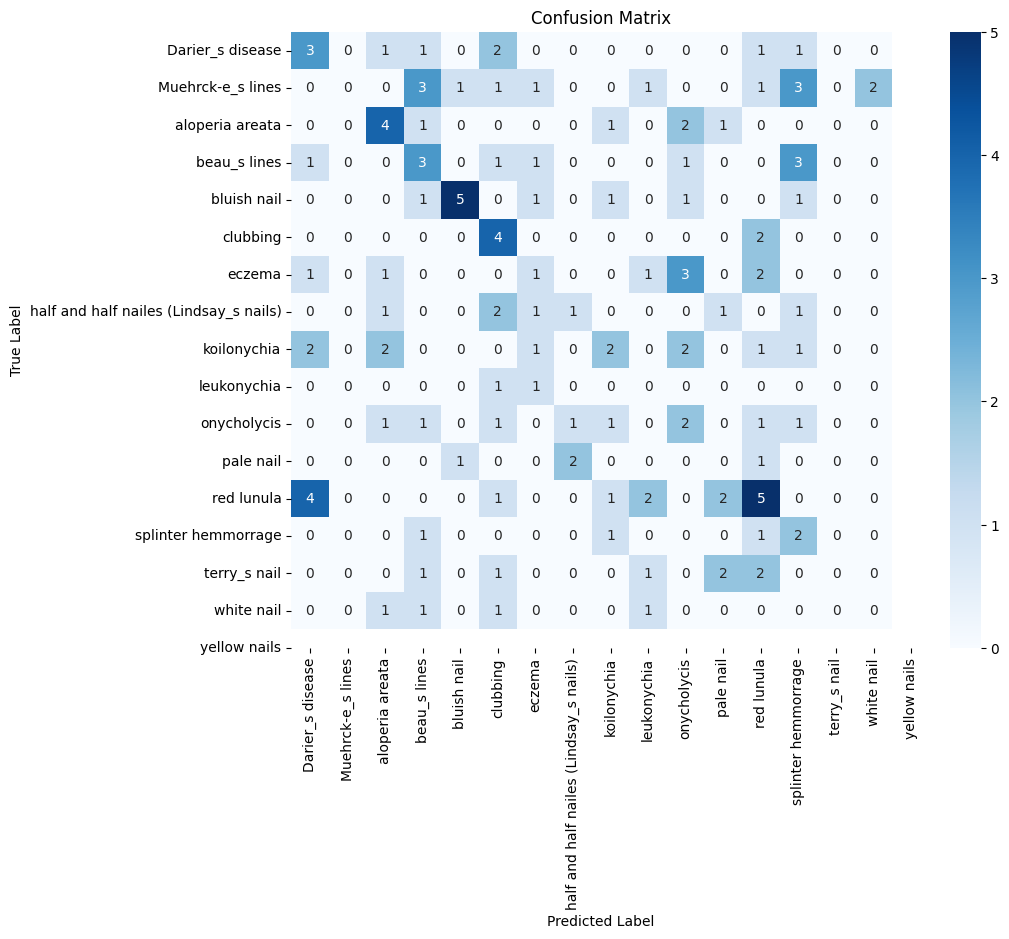

In [123]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [124]:
# Find the index of the true label
true_label_idx = class_names.index(predicted_label)

# Print specific row (true label) and column (predicted label) of the confusion matrix
print(f"True label: {class_names[true_label_idx]}, Predicted label: {predicted_label}")
print(f"Confusion Matrix Value: {conf_matrix[true_label_idx, class_names.index(predicted_label)]}")

True label: koilonychia, Predicted label: koilonychia
Confusion Matrix Value: 2


In [125]:
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.2462
